## 13.11. 全卷积网络

In [1]:
%matplotlib inline
import mindspore
import mindcv
from mindspore import nn
from mindspore.ops import functional as F
from d2l import mindspore as d2l
mindspore.set_context(device_target='GPU')

[WARNING] ME(89670:47623503916416,MainProcess):2023-03-03-02:55:21.452.349 [mindspore/common/api.py:840] 'mindspore.ms_class' will be deprecated and removed in a future version. Please use 'mindspore.jit_class' instead.
[WARNING] ME(89670:47623503916416,MainProcess):2023-03-03-02:55:21.652.203 [mindspore/common/api.py:694] 'mindspore.ms_function' will be deprecated and removed in a future version. Please use 'mindspore.jit' instead.
[WARNING] ME(89670:47623503916416,MainProcess):2023-03-03-02:55:21.667.855 [mindspore/common/api.py:694] 'mindspore.ms_function' will be deprecated and removed in a future version. Please use 'mindspore.jit' instead.


### 13.11.1. 构造模型

In [2]:
pretrained_net = mindcv.create_model('resnet18', pretrained=True)
list(pretrained_net.cells())[-3:]

[SequentialCell<
   (0): BasicBlock<
     (conv1): Conv2d<input_channels=256, output_channels=512, kernel_size=(3, 3), stride=(2, 2), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
     (bn1): BatchNorm2d<num_features=512, eps=1e-05, momentum=0.9, gamma=Parameter (name=layer4.0.bn1.gamma, shape=(512,), dtype=Float32, requires_grad=True), beta=Parameter (name=layer4.0.bn1.beta, shape=(512,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=layer4.0.bn1.moving_mean, shape=(512,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=layer4.0.bn1.moving_variance, shape=(512,), dtype=Float32, requires_grad=False)>
     (relu): ReLU<>
     (conv2): Conv2d<input_channels=512, output_channels=512, kernel_size=(3, 3), stride=(1, 1), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
     (bn2): BatchNorm2d<num_features=512, eps=1e

In [3]:
net = nn.SequentialCell(*list(pretrained_net.cells())[:-2])

In [4]:
X = d2l.rand((1, 3, 320, 480))
net(X).shape

(1, 512, 10, 15)

In [5]:
num_classes = 21
net = nn.SequentialCell(*list(pretrained_net.cells())[:-2],
                        nn.Conv2d(512, num_classes, kernel_size=1),
                        nn.Conv2dTranspose(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32, pad_mode='pad')
                       )

### 13.11.2. 初始化转置卷积层

In [6]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (d2l.arange(kernel_size).reshape(-1, 1),
          d2l.arange(kernel_size).reshape(1, -1))
    filt = (1 - d2l.abs(og[0] - center) / factor) * \
           (1 - d2l.abs(og[1] - center) / factor)
    weight = d2l.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[list(range(in_channels)), list(range(out_channels)), :, :] = filt
    return weight

In [7]:
conv_trans = nn.Conv2dTranspose(3, 3, kernel_size=4, padding=1, stride=2, pad_mode='pad',
                                has_bias=False)
conv_trans.weight.set_data(bilinear_kernel(3, 3, 4));

In [8]:
# ToTensor()输出为[0.0, 1.0]范围内且具有<C, H, W>格式的numpy数组
img = mindspore.dataset.vision.ToTensor()(d2l.Image.open('../img/catdog.jpg')) 
img = d2l.tensor(img)
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0)

input image shape: (561, 728, 3)
output image shape: (1122, 1456, 3)


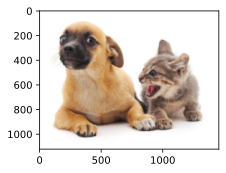

In [9]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0).numpy());
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img.numpy());

In [10]:
W = bilinear_kernel(num_classes, num_classes, 64)
net[-1].weight.set_data(W);

### 13.11.3. 读取数据集

In [11]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


### 13.11.4. 训练

[WARNING] ME(89670:47623503916416,MainProcess):2023-03-03-02:58:17.413.36 [mindspore/dataset/engine/datasets_user_defined.py:805] GeneratorDataset's num_parallel_workers: 4 is too large which may cause a lot of memory occupation (>85%) or out of memory(OOM) during multiprocessing. Therefore, it is recommended to reduce num_parallel_workers to 1 or smaller.


KeyboardInterrupt: 

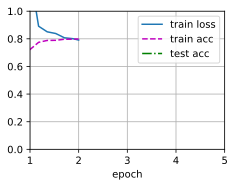

In [12]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd = 5, 0.001, 1e-3
trainer = nn.SGD(net.trainable_params(), learning_rate=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs)

### 13.11.5. 预测

In [ ]:
transform = mindspore.dataset.vision.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
def normalize_image(img):
    return transform(img.astype('float32') / 255)
    
#     d2l.tensor(X.transpose(2, 0, 1)).unsqueeze(0)
def predict(img):
#     train_iter.children[0].children[0].source.normalize_image()
    X = d2l.tensor(normalize_image(img).transpose(2, 0, 1)).unsqueeze(0)
    pred = net(X).argmax(axis=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [ ]:
colormap = mindspore.Tensor(d2l.VOC_COLORMAP)
def label2image(pred):
    X = pred.long()
    return colormap[X, :]

In [ ]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = d2l.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred.numpy(),
             d2l.crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);